# Mixture Models 

Here we review and implement typical mxiture models such as k-means, and Gaussian Mixture Models.

## Gaussian Mixture

The main purpose of Gaussian mixture model is to estimate the density of a given data set. 
Gaussian mixture model assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.
One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

Each of the Gaussian component represents a cluster. Every data point is generated by one of the Gaussian distributions in the mixture model.

- Given data $X = \{x_1,x_2, ..., x_N\}$, where $x_i \in R^D$. Assume the data can be clustered into K clusters, and each cluster is a Gaussian distribution with mean $\mu_k$ and covariance $\Sigma_k$. We want to know the marginal probability of each data point $x_i$, or $P(X)$.

    - introduce a latent multinomial variable $z = \{z_1, ..., z_K \}$, where $z_k = \{0, 1\}$, and $\sum_{k=1}^{K}z_k = 1$. $z_k$ indicates which cluster $x_i$ belongs to. $z_k = 1$ means $x_i$ belongs to cluster $k$.
    - $p(z_k = 1) = \pi_k$, where $\pi_k$ is the prior probability of cluster $k$.  $\sum_{k=1}^{K} \pi_k = 1$. Thus, $p(z) = \Pi_{k=1}^{K} \pi_k^{z_k}$.
    - $p(x|z_k = 1) = \mathcal N (x_i|\mu_k, \Sigma_k)$, where $\mathcal N (x|\mu_k, \Sigma_k)$ is the Gaussian distribution with mean $\mu_k$ and covariance $\Sigma_k$.
    - the conditional distribution is then $p(x|z) = \Pi_{k=1}^{K} \mathcal{N}(x|\mu_k, \Epsilon_k)^{z_k}$
    - the marginal distribution is $p(x) = \sum_z p(x|z)p(z) = \sum_{k=1}^{K}\pi_k \mathcal N (x|\mu_k, \Epsilon_k)$


**Maximum Likelihood**

The log likelihood of the data is:

$$\ln p(X|\pi, \mu, \Sigma) = \sum_{n=1}^{N} \ln \left\{ \sum_{k=1}^{K} \pi_k \mathcal N (x_n|\mu_k, \Sigma_k) \right\}$$


To solve the maximization problem, we use gradient vanishing method. The gradient of the log likelihood is:

- gradient of $\mu_k$:
    $$\mu_k = \frac{1}{N_k} \sum_{n=1}^{N} \gamma(z_{nk}) x_n$$
    where, 

    $$ N_k = \sum_{n=1}^{N} \gamma(z_{nk})$$
    $$ \gamma(z_{nk}) = p(z_k=1|x_n) = \frac{\pi_k \mathcal N (x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal N (x_n|\mu_j, \Sigma_j)}$$

- gradient of $\Sigma$:
    $$\Sigma_k = \frac{1}{N_k} \sum_{n=1}^{N} \gamma(z_{nk}) (x_n - \mu_k)(x_n - \mu_k)^T$$

- gradient of $\pi_k$:
    $$\pi_k = \frac{N_k}{N}$$

Note that the unknow parameters are $\pi, \mu, \Sigma$. The $\gamma$ is the responsibility of each cluster. It is the probability of $x_n$ belonging to cluster $k$.
There is no closed-form solution due to the dependency of $\gamma$ on $\mu, \Sigma$.
Iterations are needed to solve the problem.


This maximum likelihood framework is difficult to be applied to Gaussian mixture model due to:

    1) the presence of singularities where one of the components of the mixture model collapses onto one of the data points; 
    2) the identifiability problem, where the likelihood is invariant to permutations of the component indices.

Two alternatives can be used to solve the maximization of the $p(X)$:
- Gradient descent
- Expectation maximization (EM) algorithm

EM algorithm is a generalization of maximum likelihood estimation. It iteratively estimates the parameters of a statistical model. In each iteration, it performs mainly two steps:
- initialization step: initialize the parameters $\pi, \mu, \Sigma$.
- "E" step or Expection step -> evaluate the responsibilities $\gamma(z_{nk})$ using the current parameter values. 
- "M" step or Maximization step -> re-estimate the parameters $\pi, \mu, \Sigma$ using the current responsibilities.
- eVALUEate the log likelihood to check for convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied, return to the E step.

**Matrix shape analysis**:

- $X$: $N \times D$
- $\mu$: $K \times D$
- $\Sigma$: $K \times D \times D$
- $\pi$: $K \times 1$
- $\gamma$: $N \times K$



In [78]:
import jax 
import jax.numpy as jnp 
from jax.scipy.stats import multivariate_normal as norm
from scipy.stats import multivariate_normal as mvnorm
from basic.clustering.k_means import KMeans

class GaussianMixture():
    def __init__(self, num_components):
        self.num_components = num_components 
    
    def initialize_parameters(self, rng_key, data):
        """ Use kmeans to initialize the parameters of the model """
        kmeans = KMeans()
        # random obtain k centers
        means, clusters = kmeans.fit(rng_key, self.num_components, data)
        cov = jnp.stack([jnp.cov(data[clusters == i].T) for i in range(self.num_components)])
        mixing_probs = jnp.ones(self.num_components) / self.num_components
        #responsibilities = self.get_responsibilities(data, means, cov, mixing_probs)
        return means, cov, mixing_probs#,responsibilities
    
    def get_responsibilities(self, data, means, cov, mixing_probs):
        responsibilities = jnp.zeros((data.shape[0], self.num_components))
        for k in range(self.num_components):
            
            responsibilities = responsibilities.at[:,k].set(mixing_probs[k] * norm.pdf(data, means[k,:], cov[k,:,:]))
        # (N, K) = (K,) * (N, K)
        #responsibilities = mixing_probs * norm.pdf(data[:, None], means, cov)        
        responsibilities /= jnp.sum(responsibilities, axis=1, keepdims=True)

        return responsibilities
    
    # Define the E step
    def e_step(self, data, means, cov, mixing_probs):
        return self.get_responsibilities(data, means, cov, mixing_probs)

    # Define the M step
    def m_step(self, data, responsibilities):
        mixing_probs = jnp.mean(responsibilities, axis=0)
        means = jnp.zeros((self.num_components, data.shape[1]))
        cov = jnp.zeros((self.num_components, data.shape[1], data.shape[1]))
        for k in range(self.num_components):
            means_k = jnp.sum(responsibilities[:,k] * data.T, axis=1) / (mixing_probs[k] * data.shape[0])
            means = means.at[k,:].set(means_k)
            x1 = (data - means_k) 
            x2 = (data - means_k)
            # x1 and x2 are (N,D), and x1x2 is a (N, D, D) matrix
            x1x2 = (x1[:, :, None] * x2[:, None, :])
            # cov_k is a (D, D) matrix
            cov_k = jnp.sum(responsibilities[:,k][:,None, None] * x1x2, axis=0) / (mixing_probs[k] * data.shape[0])
            cov = cov.at[k].set(cov_k)

        #means = jnp.sum(responsibilities[:, :, None] * data[:, None], axis=0) / (mixing_probs[:, None] * data.shape[0])
        #cov = jnp.sum(responsibilities[:, :, None, None] * (data[:, None] - means[:, :, None]) @ (data[:, None] - means[:, :, None]).transpose(0, 1, 3, 2), axis=0) / (mixing_probs[:, None, None] * data.shape[0])
        return means, cov, mixing_probs

    def log_likelihood(self, data, means, cov, mixing_probs):
        # (N, K) = (K,) * (N, K)
        responsibilities = mixing_probs * norm.pdf(data[:, None], means, cov) 
        
        # (N, 1)
        log_likelihood = jnp.sum(jnp.log(jnp.sum(responsibilities, axis=1)))
        
        return log_likelihood

    # Define fit using E and M steps
    def fit(self, data, rng_key, num_steps=100):
        means_prev, cov_prev, mixing_probs_prev = self.initialize_parameters(rng_key, data)
        step = 0
        rel_log_likelihood = 1
        rel_tol = 1e-5
        
        log_likelihood_prev = -1e6

        while step < num_steps and rel_log_likelihood > rel_tol:
            
            responsibilities = self.e_step(data, means_prev, cov_prev, mixing_probs_prev)
            # m_step
            means, cov, mixing_probs = self.m_step(data, responsibilities)
            print('means shape ', means.shape)
            log_likelihood = self.log_likelihood(data, means, cov, mixing_probs)
            rel_log_likelihood = jnp.abs(log_likelihood - log_likelihood_prev) / (jnp.abs(log_likelihood_prev) + 1e-6)

            # stop if parameter converge 
            
            if jnp.allclose(means, means_prev) and jnp.allclose(cov, cov_prev) and jnp.allclose(mixing_probs, mixing_probs_prev):
                print("Parameters converged")
                break
            
            # update state
            step += 1
            means_prev = means.copy()
            cov_prev = cov.copy()
            mixing_probs_prev = mixing_probs.copy()
            
            
        return means, cov, mixing_probs, responsibilities
    

In [79]:
import numpy as np 
import jax.random as random

# training data
np.random.seed(0)

# randomly generate clusters
samples = 10000
x1 = np.random.normal(size=(samples, 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(samples, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(samples, 2))
x3 += np.array([0, 5])
x_train = np.vstack((x1, x2, x3))

x0, x1 = np.meshgrid(np.linspace(-10, 10, samples), np.linspace(-10, 10, samples))
x = np.array([x0, x1]).reshape(2, -1).T

# seed
key1, key2 = random.split(random.PRNGKey(0), 2)

# gaussian mixture model
gmm = GaussianMixture(num_components=3)
means, cov, mixing_coeff, responsibilities = gmm.fit(x_train, key1, num_steps=100)

cluster = responsibilities.argmax(axis=1)


means shape  (3, 2)
means shape  (3, 2)
Parameters converged


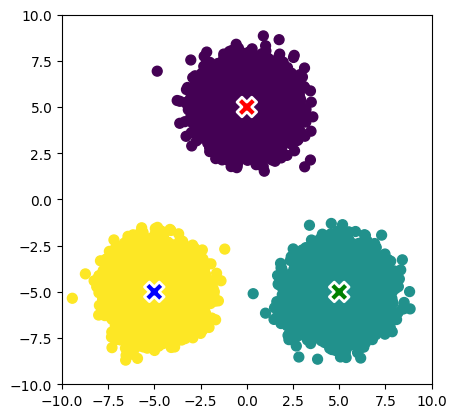

In [81]:
import matplotlib.pyplot as plt


plt.scatter(x_train[:, 0], x_train[:, 1], c=cluster, s=50)
plt.scatter(means[:, 0], means[:, 1], s=200, marker='X', lw=2, c=['red', 'green', 'blue'], edgecolor="white")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect("equal")
plt.show()